## Face Mask Detection using PyTorch

### Objective :
 - Detect if a person is wearing a mask, wearing it incorrectly, or not wearing a mask at all using images and annotations.  
 - We will preprocess data, visualize annotations, create a dataset, train a deep learning model (ResNet34), and evaluate performance.

#### 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from collections import Counter
import os
import warnings
warnings.filterwarnings("ignore")

import torch
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import xmltodict
import torch.optim as optim
import torch.nn as nn


In [2]:
# Check PyTorch version
print(f"PyTorch Version: {torch.__version__}")

PyTorch Version: 2.4.1+cu118


### 2. Load Image and Annotation Files

In [3]:
# Define paths
IMG_DIR = r"archive\images"
ANNOT_DIR = r"archive\annotations"

# Separate image and annotation files
img_names, xml_names = [], []
for dirname, _, filenames in os.walk(IMG_DIR):
    for filename in filenames:
        if filename.endswith(".xml"):
            xml_names.append(filename)
        else:
            img_names.append(filename)

print(f"Total Images: {len(img_names)}, Annotations: {len(xml_names)}")

Total Images: 853, Annotations: 0


### 3. Analyze Classes in the Dataset

Class Distribution: Counter({'with_mask': 3232, 'without_mask': 717, 'mask_weared_incorrect': 123})


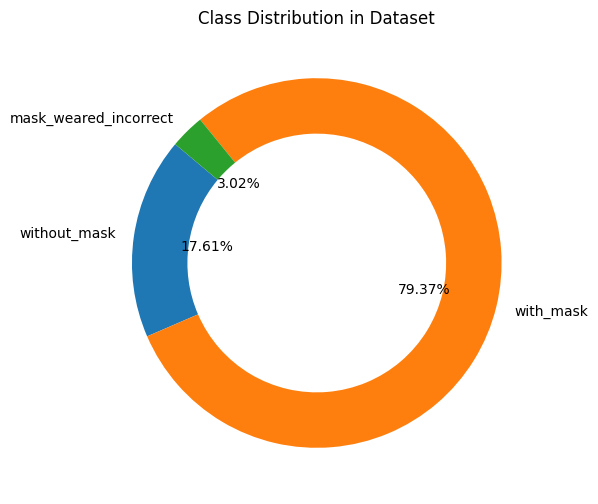

In [4]:
# Count occurrences of each class from XML annotations
def get_class_distribution(img_list):
    class_list = []
    for img_name in img_list:
        with open(f"{ANNOT_DIR}/{img_name[:-4]}.xml") as fd:
            doc = xmltodict.parse(fd.read())
            objects = doc["annotation"]["object"]
            if isinstance(objects, list):
                for obj in objects:
                    class_list.append(obj["name"])
            else:
                class_list.append(objects["name"])
    return Counter(class_list)

class_counts = get_class_distribution(img_names)
print("Class Distribution:", class_counts)

# Visualize the class distribution
plt.figure(figsize=(8, 6))
plt.pie(class_counts.values(), labels=class_counts.keys(), 
        autopct='%1.2f%%', startangle=140, wedgeprops=dict(width=0.3))
plt.title("Class Distribution in Dataset")
plt.show()


### 4. Visualize Annotations on Sample Images

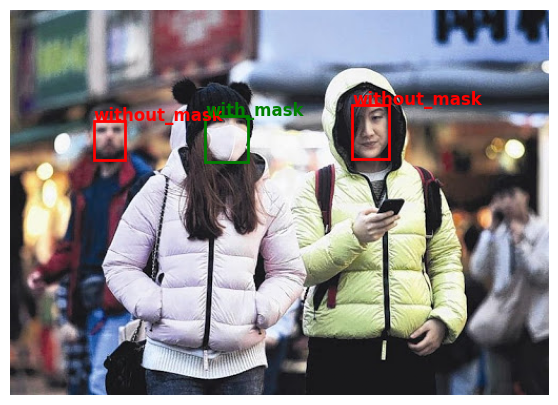

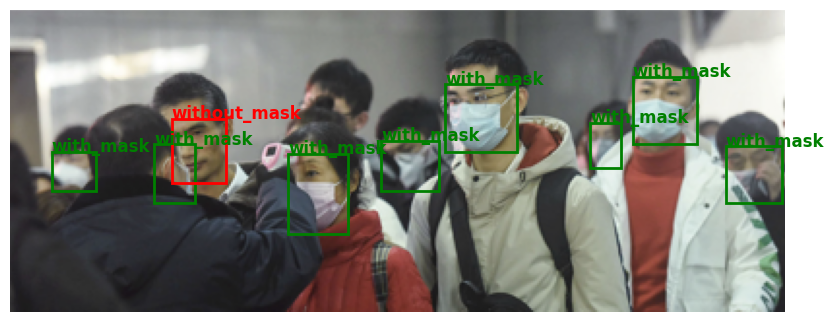

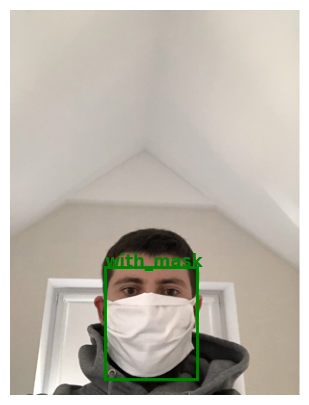

In [5]:
def visualize_annotations(img_name):
    """Visualize bounding boxes and labels on an image."""
    with open(f"{ANNOT_DIR}/{img_name[:-4]}.xml") as fd:
        doc = xmltodict.parse(fd.read())

    image = plt.imread(os.path.join(IMG_DIR, img_name))
    fig, ax = plt.subplots(1, figsize=(10, 5))
    ax.imshow(image)
    ax.axis("off")

    objects = doc["annotation"]["object"]
    if not isinstance(objects, list):
        objects = [objects]

    for obj in objects:
        x, y, w, h = map(int, obj["bndbox"].values())
        color = {"with_mask": "green", "without_mask": "red", "mask_weared_incorrect": "yellow"}[obj["name"]]
        rect = mpatches.Rectangle((x, y), w-x, h-y, edgecolor=color, facecolor='none', linewidth=2)
        ax.add_patch(rect)
        ax.text(x, y, obj["name"], color=color, fontsize=12, fontweight="bold")

    plt.show()

# Display annotations for a few images
for i in range(3):
    visualize_annotations(img_names[i])

### 5. Preprocess Data

In [6]:
# Define transformations
my_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Map class names to numeric labels
class_map = {"with_mask": 0, "without_mask": 1, "mask_weared_incorrect": 2}

def create_dataset(img_list):
    """Create a dataset with image tensors and labels."""
    data = []
    for img_name in img_list:
        with open(f"{ANNOT_DIR}/{img_name[:-4]}.xml") as fd:
            doc = xmltodict.parse(fd.read())
            objects = doc["annotation"]["object"]
            if not isinstance(objects, list):
                objects = [objects]
            
            for obj in objects:
                x, y, w, h = map(int, obj["bndbox"].values())
                label = class_map[obj["name"]]
                image = Image.open(f"{IMG_DIR}/{img_name}").convert("RGB")
                cropped_img = transforms.functional.crop(image, y, x, h-y, w-x)
                data.append((my_transform(cropped_img), torch.tensor(label)))

    return data

# Create dataset and display sample shape
dataset = create_dataset(img_names)
print(f"Total Samples: {len(dataset)}")
print(f"Sample Tensor Shape: {dataset[0][0].shape}, Label: {dataset[0][1]}")


Total Samples: 4072
Sample Tensor Shape: torch.Size([3, 224, 224]), Label: 1


### 6. Split Data into Train and Test Sets

In [7]:
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_data, test_data = random_split(dataset, [train_size, test_size])

print(f"Train Size: {train_size}, Test Size: {test_size}")


Train Size: 2850, Test Size: 1222


### 7. Create DataLoaders

In [8]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=4)

### 8. Build and Initialize the Model


In [9]:
# Load pretrained ResNet34
model = models.resnet34(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 3)  # 3 output classes

# Freeze feature layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the final layer
for param in model.fc.parameters():
    param.requires_grad = True

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

### 9. Train the Model

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

n_epochs = 2
for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

print("Training Completed.")


Epoch 1, Loss: 0.5136
Epoch 2, Loss: 0.3724
Training Completed.


### 10. Save the Trained Model

In [11]:
def save_model(model, path='face_mask_model.pth'):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

save_model(model)

Model saved to face_mask_model.pth


### 11. Visualize Sample Predictions

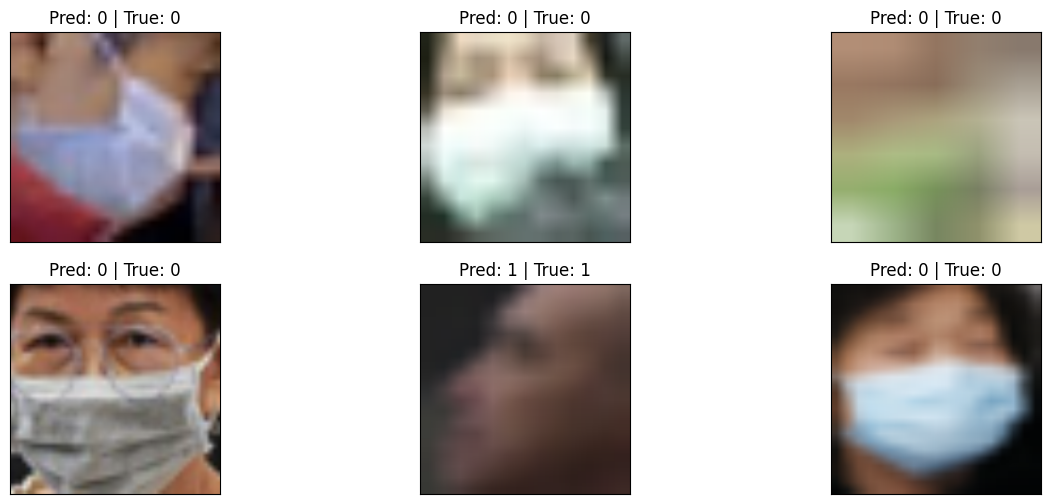

In [12]:
def visualize_predictions(model, loader):
    model.eval()
    inputs, labels = next(iter(loader))
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)

    fig = plt.figure(figsize=(15, 6))
    for i in range(6):
        ax = fig.add_subplot(2, 6//2, i+1, xticks=[], yticks=[])
        plt.imshow(np.transpose(inputs[i].cpu().numpy(), (1, 2, 0)))
        ax.set_title(f"Pred: {preds[i].item()} | True: {labels[i].item()}")

visualize_predictions(model, test_loader)
